In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as MVN
from numpy import zeros, eye, log
from numpy.linalg import norm
import matplotlib.colors as mcolors


from utils import prep_contour
import mici
from functools import partial

In [36]:
def F(θ):
    return np.array([θ[1]**2 + 3 * θ[0]**2 * (θ[0]**2 - 1)])

In [106]:
def F_broadcast(θ_mat):
    return θ_mat[:, 1]**2 + 3 * θ_mat[:,0]**2 * (θ_mat[:,0]**2 - 1)

In [129]:
def log_posterior_dens(θ, σ, y):
    return -(np.sum(θ**2, 0) + norm(y - F(θ))**2 / σ**2) / 2

In [130]:
def log_posterior_dens_broadcast(θ, σ, y):
    return -(np.sum(θ**2, 1) + (y - F_broadcast(θ))**2 / σ**2) / 2

In [38]:
prior_log_dens = lambda x: MVN(zeros(2), eye(2)).logpdf(x)

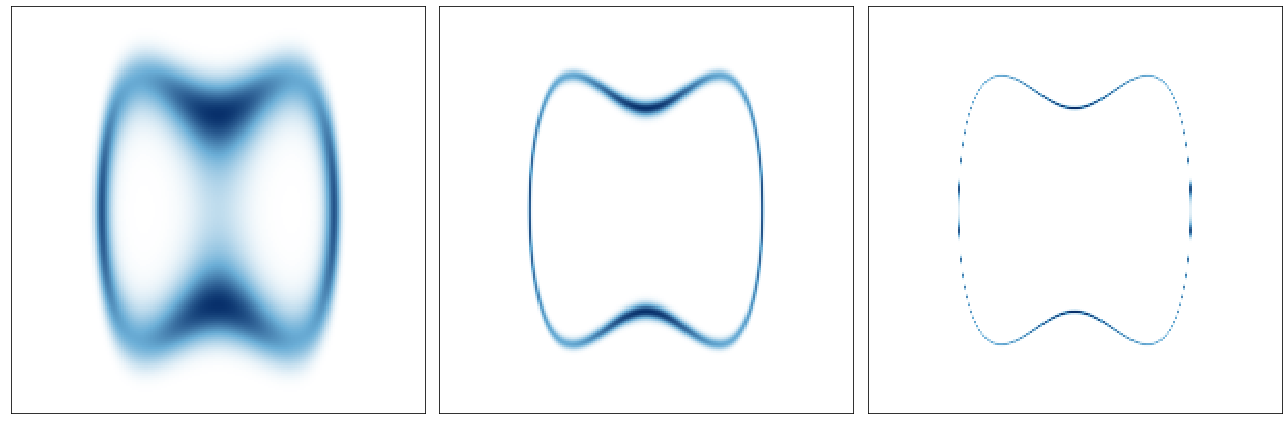

In [174]:
logpost1 = lambda θ: log_posterior_dens_broadcast(θ, σ=0.5, y=1.0)
logpost2 = lambda θ: log_posterior_dens_broadcast(θ, σ=0.1, y=1.0)
logpost3 = lambda θ: log_posterior_dens_broadcast(θ, σ=0.02, y=1.0)

θ_grid = np.stack(
    np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))
)

dens_cmap = mcolors.LinearSegmentedColormap.from_list(
    'whiteblue', [np.array((1.000, 1.000, 1.000, 1.)),
                  np.array((0.419, 0.682, 0.840, 1.)),
                  np.array((0.031, 0.188, 0.420, 1.))])

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
#ax.contour(*prep_contour([-2, 2], [-2, 2], 0.01, logpost3), levels=[-4000, -3500, -3000, -2500, -2000,-1500, -1000])
ax[0].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.5, 1.0)), cmap=dens_cmap, shading='auto')
ax[1].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.1, 1.0)), cmap=dens_cmap, shading='auto')
ax[2].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.02, 1.0)), cmap=dens_cmap, shading='auto')

for i in range(3):
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    plt.tight_layout()
plt.savefig("figures/bip_density.png", dpi=500)
plt.show()

In [241]:
import symnum.numpy as snp
from symnum import (
    numpify, named_array, jacobian, grad, 
    vector_jacobian_product, matrix_hessian_product)
import sympy

seed = 20200310
rng = np.random.default_rng(seed)
dim_θ = 2
dim_y = 1

σ = 0.1
y = 1

_ = np.seterr(invalid='ignore', over='ignore')

@numpify(dim_θ)
def forward_func(θ):
    return snp.array([θ[1]**2 + 3 * θ[0]**2 * (θ[0]**2 - 1)])

@numpify(dim_θ, None, None)
def neg_log_posterior_dens(θ, σ, y):
    return (snp.sum(θ**2, 0) + snp.sum((y - forward_func(θ))**2, 0) / σ**2) / 2

grad_and_val_neg_log_posterior_dens = grad(
    neg_log_posterior_dens, return_aux=True)

state = mici.states.ChainState(
    pos=np.array([0.0, -1.0]), mom=None, dir=1)
state.mom = system.sample_momentum(state, rng)

In [242]:
def sample_staticHMC(state, N, σ, y):
    system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
    grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y))
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=0.05)
    sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=20)
    final_state, trace, stats = sampler.sample_chain(n_iter=2000, init_state=state, display_progress=False)
    return final_state, trace, stats

In [243]:
fs1, t1, s1 = sample_staticHMC(state, 2000, 0.5, 1.0)
fs2, t2, s2 = sample_staticHMC(state, 2000, 0.1, 1.0)
fs3, t3, s3 = sample_staticHMC(state, 2000, 0.02, 1.0)

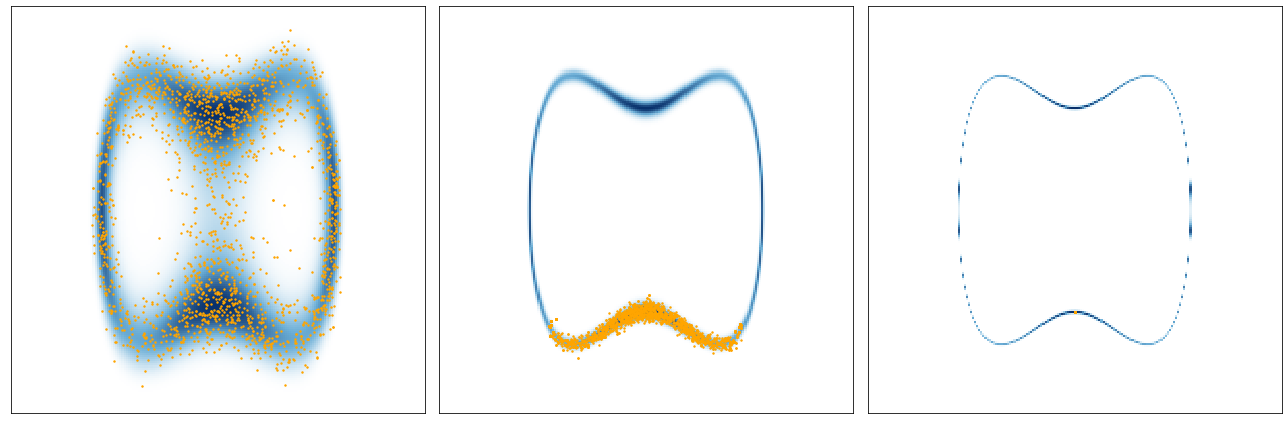

In [250]:
logpost1 = lambda θ: log_posterior_dens_broadcast(θ, σ=0.5, y=1.0)
logpost2 = lambda θ: log_posterior_dens_broadcast(θ, σ=0.1, y=1.0)
logpost3 = lambda θ: log_posterior_dens_broadcast(θ, σ=0.02, y=1.0)

θ_grid = np.stack(
    np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))
)

dens_cmap = mcolors.LinearSegmentedColormap.from_list(
    'whiteblue', [np.array((1.000, 1.000, 1.000, 1.)),
                  np.array((0.419, 0.682, 0.840, 1.)),
                  np.array((0.031, 0.188, 0.420, 1.))])

fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
#ax.contour(*prep_contour([-2, 2], [-2, 2], 0.01, logpost3), levels=[-4000, -3500, -3000, -2500, -2000,-1500, -1000])
ax[0].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.5, 1.0)), cmap=dens_cmap, shading='auto')
ax[0].scatter(*t1['pos'].T, s=2, color='orange')
ax[1].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.1, 1.0)), cmap=dens_cmap, shading='auto')
ax[1].scatter(*t2['pos'].T, s=2, color='orange')
ax[2].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.02, 1.0)), cmap=dens_cmap, shading='auto')
ax[2].scatter(*t3['pos'].T, s=2, color='orange')

for i in range(3):
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    plt.tight_layout()
plt.savefig("figures/bip_density_with_samples.png", dpi=500)
plt.show()